In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
import shutil
from tqdm import tqdm

from fastai.vision.all import *
from fastai.metrics import accuracy_multi

from scipy.fft import fft, ifft
from scipy import interpolate

random.seed(2024)

In [ ]:
# author's code: https://github.com/dxganta/eeg-deep-learning/blob/main/mnist_digit_detection.ipynb

In [ ]:
# author's dataset not provided
# so we use data from https://huggingface.co/datasets/DavidVivancos/MindBigData2022_MNIST_MU

In [97]:
# trainpath = "/home/tyeeying/school/cs5242/project/data/datasets--DavidVivancos--MindBigData2022_MNIST_EP/snapshots/eadb3c19dcf97f579393883947fe0c650690365f/train.csv"
trainpath = "/home/tyeeying/school/cs5242/project/data/datasets--DavidVivancos--MindBigData2022_MNIST_MU/snapshots/b126db0f2388da3aee9d5193397487a69c625a7e/train.csv"
train = pd.read_csv(trainpath)
train = train[train.label != -1]
train.index = range(len(train))
# testpath = "/home/tyeeying/school/cs5242/project/data/datasets--DavidVivancos--MindBigData2022_MNIST_EP/snapshots/eadb3c19dcf97f579393883947fe0c650690365f/test.csv"
testpath = "/home/tyeeying/school/cs5242/project/data/datasets--DavidVivancos--MindBigData2022_MNIST_MU/snapshots/b126db0f2388da3aee9d5193397487a69c625a7e/test.csv"
test = pd.read_csv(testpath)
test = test[test.label != -1]
test.index = range(len(test))

In [100]:
# sample from train (only look at 0, 3, 6, 9 -- simplify problem first)
sampled_train = []
for l in [0, 3, 6]: # [0, 3, 6], [-1, 9], [0, 9]
    sampled_train.append(train[train.label == l].sample(1000, random_state = 2024)) #1000, 500
sampled_train = pd.concat(sampled_train, ignore_index = True)

In [101]:
# sample from test (only look at 0, 3, 6, 9 -- simplify problem first)
sampled_test = []
for l in [0, 3, 6]: # [0, 3, 6], [-1, 9], [0, 9]
    sampled_test.append(test[test.label == l].sample(200, random_state = 2024)) #200, 250
sampled_test = pd.concat(sampled_test, ignore_index = True)

In [102]:
sampled_train.shape, sampled_test.shape

((3000, 1761), (600, 1761))

In [103]:
sampled_train.label.value_counts()

label
0    1000
3    1000
6    1000
Name: count, dtype: int64

In [104]:
sampled_test.label.value_counts()

label
0    200
3    200
6    200
Name: count, dtype: int64

In [105]:
# total channels
len(set([c.split("-")[0] for c in sampled_train.columns])) - 1

4

In [106]:
# number of EEG recordings in the 2s interval
for c in set([c.split("-")[0] for c in sampled_train.columns]):
    if c[-1].isnumeric():
        print(c, sum([1 for d in sampled_train.columns if d.startswith(c)]))

FP2 440
FP1 440
TP9 440
TP10 440


In [190]:
# should we average across channels (according to author is more or less the same), they did so and so divided 4 for total number of datapoints
# for now we just use FP1

In [107]:
# don't really understand this part...
srate = 220

def time_frequency(data, cmwX, nKern):
    ''''
    Function to calculate time-frequency representation of multichannel data.

    Parameters:
    data : ndarray
        The EEG data, array of shape (channels, time).
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    channel_labels : list, optional
        The labels of the EEG channels. Must be the same length as the number of channels in the data.
        If not provided, no channel labels will be used.

    Returns:
    tf : ndarray
        The time-frequency representation of the data, array of shape (frequencies, time).
        This is the average power across all channels.
    '''

    # set up convolution parameters
    nData   = data.shape[1]
    nConv   = nData + nKern - 1
    halfwav = (nKern-1)//2

    # initialize time-frequency output matrix
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1])) # channels X frequency X times

    # loop over channels
    for chani in range(data.shape[0]):

        # compute Fourier coefficients of EEG data
        eegX = fft(data[chani, :] , nConv)

        # perform convolution and extract power (vectorized across frequencies)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        as_ = as_[:, halfwav: -halfwav]
        tf[chani, :, :] = np.abs(as_) ** 2

    return tf


def get_cmwX(nData, freqrange=[1,40], numfrex=42):
    '''
    Function to calculate the Fourier coefficients of complex Morlet wavelets.

    Parameters:
    nData : int
        The number of data points.
    freqrange : list, optional
        The range of frequencies to consider. Defaults to [1,40].
    numfrex : int, optional
        The number of frequencies between the lowest and highest frequency. Defaults to 42.

    Returns:
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    frex : ndarray
        The array of frequencies.
    '''
    pi = np.pi
    wavtime = np.arange(-2,2-1/srate,1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0],freqrange[1],numfrex)
   # create complex morlet wavelets array
    cmwX = np.zeros((numfrex, nConv), dtype=complex)

    # number of cycles
    numcyc = np.linspace(3,15,numfrex);
    for fi in range(numfrex):
        # create time-domain wavelet
        s = numcyc[fi] / (2*pi*frex[fi])
        twoSsquared = (2*s) ** 2
        cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )


        # compute fourier coefficients of wavelet and normalize
        cmwX[fi, :] = fft(cmw, nConv)
        cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])

    return cmwX, nKern, frex

In [108]:
# combine train (first 3000) and test (last 600)
combined = pd.concat([sampled_train, sampled_test], ignore_index = True)
FP1 = combined[[c for c in combined.columns if c.startswith("FP1")]]
FP2 = combined[[c for c in combined.columns if c.startswith("FP2")]]
TP9 = combined[[c for c in combined.columns if c.startswith("TP9")]]
TP10 = combined[[c for c in combined.columns if c.startswith("TP10")]]
codes = combined["label"]
# testing on one channel
data_array = FP1.to_numpy()
data_array.shape, codes.shape

((3600, 440), (3600,))

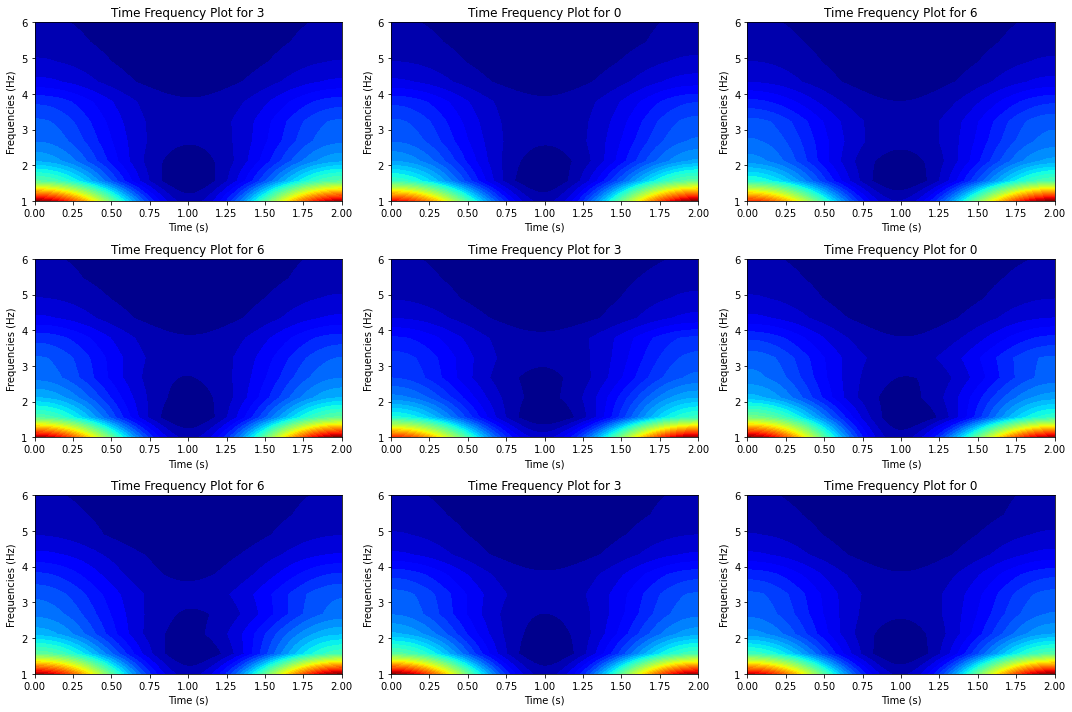

In [109]:
###
# hyperparameters (according to the author, say can play around with starting_freq and end_freq)
starting_freq = 1
end_freq = 6
num_frequencies = 10
###
median_length = 440

times = np.linspace(0,2,median_length)
nData = data_array.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
    x = random.randint(0, tf.shape[0])
    contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequencies (Hz)')
    ax.set_title(f"Time Frequency Plot for {codes[x]}")

fig.tight_layout()

In [110]:
tf.shape

(3600, 10, 440)

In [111]:
frex.shape

(10,)

In [112]:
times.shape

(440,)

In [113]:
# Saving Time-Frequency Figures as png files
path = "/home/tyeeying/school/cs5242/project/data/MU-time-frequency"

def get_path(i, path, code):
    if i < 3000: ### 3000, 1000
        return os.path.join(path, "training", str(code))
    else:
        return os.path.join(path, "test", str(code))

mapper = {0:0, 3:1, 6:2} #{0:0, 3:1, 6:2}, {-1:0, 9:1}, {0: 0, 9: 1}
    
for i in tqdm(range(tf.shape[0]), desc = "Processing data points..."):
    code = mapper[codes[i]]
    folder_path =  get_path(i, path, code)
    os.makedirs(folder_path, exist_ok=True)

    fig, ax = plt.subplots()
    ax.contourf(times, frex, tf[i,:,:], 40, cmap='jet')
    ax.axis('off')

    # Save the figure as a PNG file with a tight bounding box
    file_path = f"{folder_path}/{i}.png"
    fig.savefig(file_path, bbox_inches='tight', pad_inches=0)

    # Clear the current figure to free memory
    fig.clf()
    plt.close()

Processing data points...: 100%|█████████████████████████████████████████████████████| 3600/3600 [02:41<00:00, 22.24it/s]


In [114]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [ ]:
# for some reason, even though specify train='training', it still takes training data from test...
# pls mv test to another folder first

In [115]:
path = "/home/tyeeying/school/cs5242/project/data/MU-time-frequency/"
# /home/tyeeying/.cache/torch/hub/checkpoints/resnet34-b627a593.pth (model stored here)
dls = ImageDataLoaders.from_folder(path, train='training', valid_pct=0.2, item_tmfs=Resize(224), bs = 128)
# dls.show_batch()
learn = vision_learner(dls, resnet34, metrics=accuracy)
lr = 1e-2
learn.fit_one_cycle(10, slice(lr))
# learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.004704,1.397423,0.320000,00:17
1,1.708837,1.568941,0.358333,00:18
2,1.480871,1.400893,0.333333,00:17
3,1.337693,1.340131,0.331667,00:19
4,1.213186,1.441147,0.315000,00:18
5,1.088374,1.459291,0.300000,00:19
6,0.979218,1.510816,0.315000,00:18
7,0.870596,1.560833,0.313333,00:18
8,0.776069,1.586487,0.308333,00:18
9,0.705175,1.589303,0.305000,00:18


In [116]:
# can check what is in train
# if nv move test folder out, will have test inside as well... data leakage...
# author nv did tat, they probably training and testing on the same data, tats why high accuracy...
# tested out binary -1 or 9
# (without data leakage is ~75% accuracy, with data leakage is ~95%)
# with data leakage, [abt same as what author reported... high accuracy is from data leakage defintely]

dls.train.items

[Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/2/2205.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/0/886.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/0/153.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/0/486.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/2/2382.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/2/2023.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/0/12.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/0/726.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/2/2185.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/2/2944.png'),
 Path('/home/tyeeying/school/cs5242/project/data/MU-time-frequency/training/0/345.png'),
 Path('/home/tyee

In [117]:
test_path = "/home/tyeeying/school/cs5242/project/data/test"
# test_path = "/home/tyeeying/school/cs5242/project/data/MU-time-frequency/test"
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files, with_labels=True)
test_loss, test_accuracy = learn.validate(dl=test_dl)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

Test accuracy is 34.00%


In [118]:
path = "/home/tyeeying/school/cs5242/project/data/MU-time-frequency/"
# /home/tyeeying/.cache/torch/hub/checkpoints/resnet34-b627a593.pth (model stored here)
dls = ImageDataLoaders.from_folder(path, train='training', valid_pct=0.2, item_tmfs=Resize(224), bs = 128)
# dls.show_batch()
learn = vision_learner(dls, resnet34, metrics=accuracy)
lr = 1e-2
learn.fit_one_cycle(20, slice(lr))
# learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.928910,1.883441,0.341667,00:18
1,1.749533,1.482857,0.350000,00:18
2,1.529888,1.577972,0.316667,00:17
3,1.378981,1.305538,0.325000,00:18
4,1.263605,1.587510,0.330000,00:18
5,1.199051,1.502839,0.348333,00:18
6,1.124563,1.578300,0.308333,00:19
7,1.050400,1.528253,0.335000,00:18
8,0.974179,1.675787,0.333333,00:18
9,0.901348,1.657255,0.343333,00:21


In [119]:
test_path = "/home/tyeeying/school/cs5242/project/data/test"
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files, with_labels=True)
test_loss, test_accuracy = learn.validate(dl=test_dl)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

Test accuracy is 33.00%


In [ ]:
# try this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10708586/pdf/sensors-23-09351.pdf (described in paper the CNN architecture used...)